# Practical Lab 1: Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts

## Overview
This notebook implements a predictive maintenance system for industrial current data (axes 1-8). It:
- Connects to a Neon.tech PostgreSQL database to pull training data.
- Fits linear regression models (Time → Axis values) for axes 1-8.
- Analyzes residuals to discover alert/error thresholds (MinC, MaxC, T).
- Generates synthetic test data to simulate streaming.
- Detects alerts/errors based on thresholds and logs events.
- Visualizes regression fits, residuals, and annotated alerts/errors.

The goal is to detect anomalies in current data to flag potential failures early, using evidence-based thresholds.

## Load Environment and Connect to Database
Pull training data from Neon.tech PostgreSQL, convert time to numeric, and export to CSV.

In [97]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load .env file
load_dotenv()

PGHOST = os.getenv('PGHOST')
PGPORT = os.getenv('PGPORT', '5432')
PGDATABASE = os.getenv('PGDATABASE')
PGUSER = os.getenv('PGUSER')
PGPASSWORD = os.getenv('PGPASSWORD')
PGSSL = os.getenv('PGSSL', 'require')

assert PGHOST and PGDATABASE and PGUSER and PGPASSWORD, ' Missing DB env vars. Check your .env file!'

# Build SQLAlchemy engine
engine = create_engine(
    f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}?sslmode={PGSSL}',
    pool_pre_ping=True
)

# Query staging_measurements
query = '''
SELECT time, axis1, axis2, axis3, axis4, axis5, axis6, axis7, axis8
FROM staging_measurements
'''

# Load into DataFrame
df_train = pd.read_sql(query, engine)

# Ensure datetime and sort
df_train['time'] = pd.to_datetime(df_train['time'])
df_train.sort_values('time', inplace=True)

# Convert time to numeric (seconds since start)
df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Save to CSV
os.makedirs('Data', exist_ok=True)
df_train.to_csv('Data/Training_data.csv', index=False)

print('Data exported from staging_measurements to Data/Training_data.csv')
print(df_train.head())

Data exported from staging_measurements to Data/Training_data.csv
                              time  axis1  axis2  axis3  axis4  axis5  axis6  axis7  axis8  time_numeric
0 2022-10-17 12:18:23.660000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         0.000
1 2022-10-17 12:18:25.472000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         1.812
2 2022-10-17 12:18:27.348000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         3.688
3 2022-10-17 12:18:29.222000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         5.562
4 2022-10-17 12:18:31.117000+00:00    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0         7.457


## Train Linear Regression Models and Analyze Residuals
Fit univariate regression models (Time → Axes 1-8), compute slopes/intercepts, and analyze residuals.

In [98]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 20)

DATA_DIR = Path('Data')
DATA_DIR.mkdir(parents=True, exist_ok=True)
AXES = ['axis1', 'axis2', 'axis3', 'axis4', 'axis5', 'axis6', 'axis7', 'axis8']

# Load training data
train_path = DATA_DIR / 'Training_data.csv'
assert train_path.exists(), 'Training_data.csv not found. Run DB cell first.'
df_train = pd.read_csv(train_path)
df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce')
df_train = df_train.sort_values('time').reset_index(drop=True)

# Ensure time_numeric
if 'time_numeric' not in df_train.columns:
    df_train['time_numeric'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds()

# Drop missing values
df_train = df_train.dropna(subset=['time_numeric'] + AXES)

# Estimate sampling interval
time_diffs = df_train['time'].diff().dt.total_seconds()
sample_interval_sec = float(np.nanmedian(time_diffs))
print(f'Estimated sampling interval: {sample_interval_sec:.3f} seconds')

# Fit models
models = {}
slopes = {}
intercepts = {}
residuals_dict = {}
X = df_train[['time_numeric']].values

for axis in AXES:
    y = df_train[axis].values.astype(float)
    mdl = LinearRegression()
    mdl.fit(X, y)
    models[axis] = mdl
    slopes[axis] = float(mdl.coef_[0])
    intercepts[axis] = float(mdl.intercept_)
    y_pred = mdl.predict(X)
    residuals_dict[axis] = y - y_pred

# Summaries
model_summary = pd.DataFrame({
    'axis': AXES,
    'slope': [slopes[a] for a in AXES],
    'intercept': [intercepts[a] for a in AXES]
}).sort_values('axis')

# Compute residual stats (mean and std for each axis)
residual_stats = pd.DataFrame({
    'axis': AXES,
    'residual_mean': [float(np.mean(residuals_dict[a])) for a in AXES],
    'residual_std': [float(np.std(residuals_dict[a], ddof=0)) for a in AXES],
}).sort_values('axis').reset_index(drop=True)

# Save artifacts
model_summary.to_csv(DATA_DIR / 'model_params.csv', index=False)
residual_stats.to_csv(DATA_DIR / 'residual_stats.csv', index=False)

print('\n Model parameters (slopes/intercepts):')
print(model_summary)
print('\n Residual stats (mean/std):')
print(residual_stats)
print('\n Ready: models, residuals_dict, model_params.csv, residual_stats.csv')

Estimated sampling interval: 1.891 seconds

 Model parameters (slopes/intercepts):
    axis         slope  intercept
0  axis1 -1.176729e-07   0.730542
1  axis2  2.194203e-06   3.523886
2  axis3 -5.777186e-07   2.733898
3  axis4  3.890034e-07   0.604357
4  axis5  8.381178e-08   0.951103
5  axis6  4.744455e-07   0.580077
6  axis7  5.537186e-07   0.847563
7  axis8  8.499989e-08   0.098748

 Residual stats (mean/std):
    axis  residual_mean  residual_std
0  axis1  -1.719402e-17      2.162091
1  axis2   2.751043e-16      6.879688
2  axis3  -4.585071e-17      5.111819
3  axis4   9.170142e-17      1.574851
4  axis5  -1.490148e-16      2.100159
5  axis6  -9.743276e-17      1.815442
6  axis7   1.146268e-16      2.166746
7  axis8   1.146268e-17      0.423065

 Ready: models, residuals_dict, model_params.csv, residual_stats.csv


## Visualize Regression Fits and Residuals
Plot training data with regression lines and residual distributions to identify patterns.

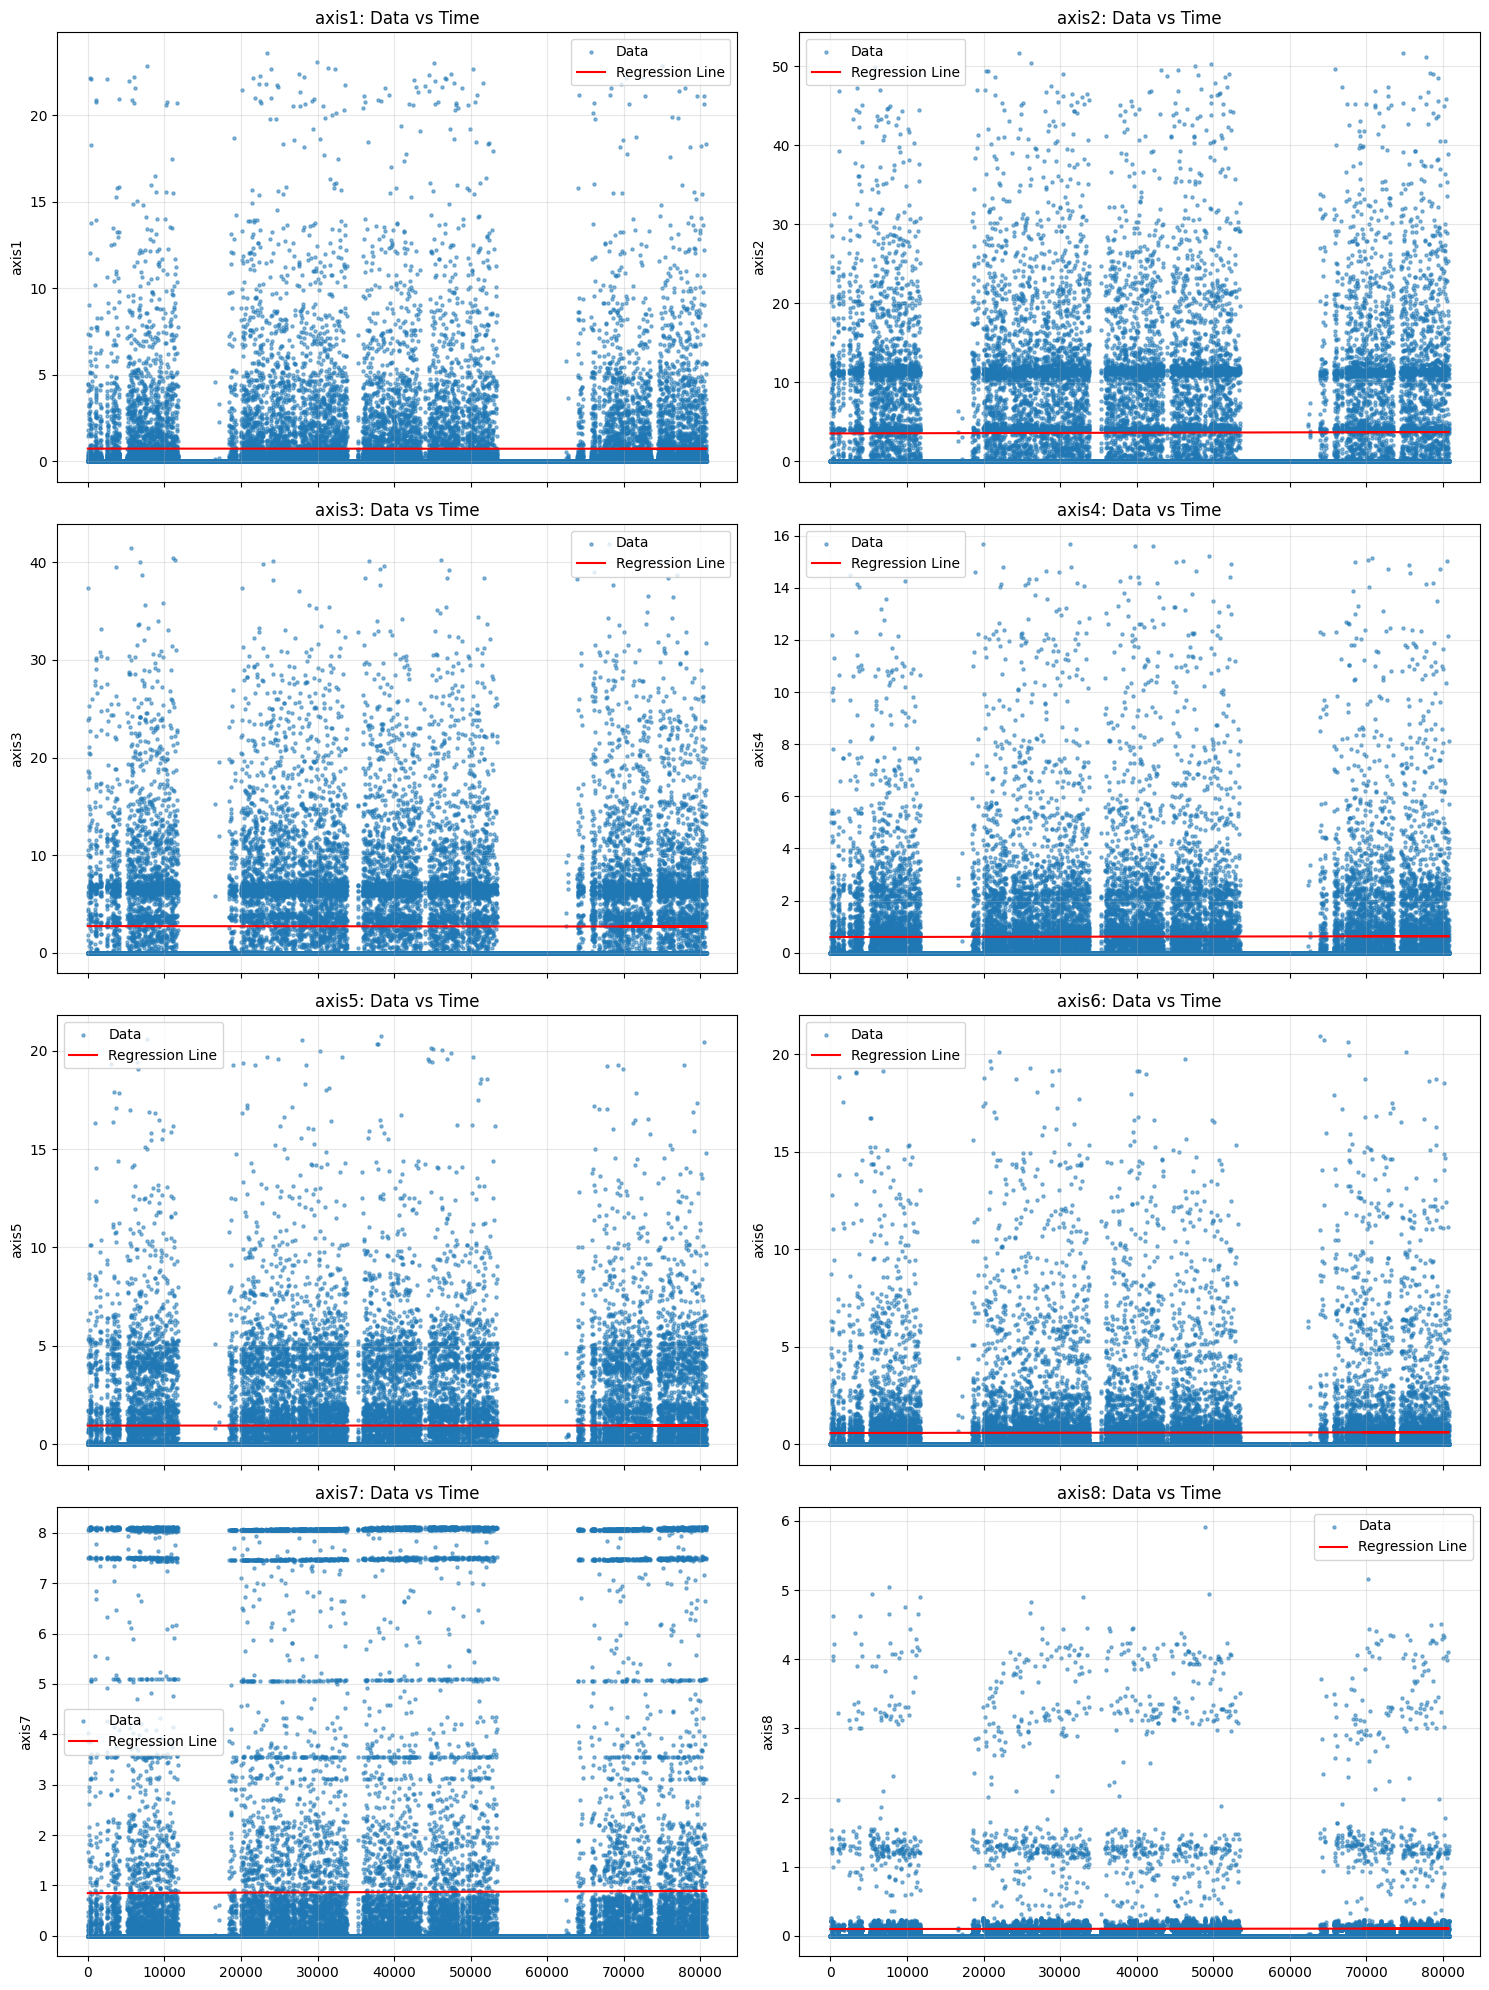

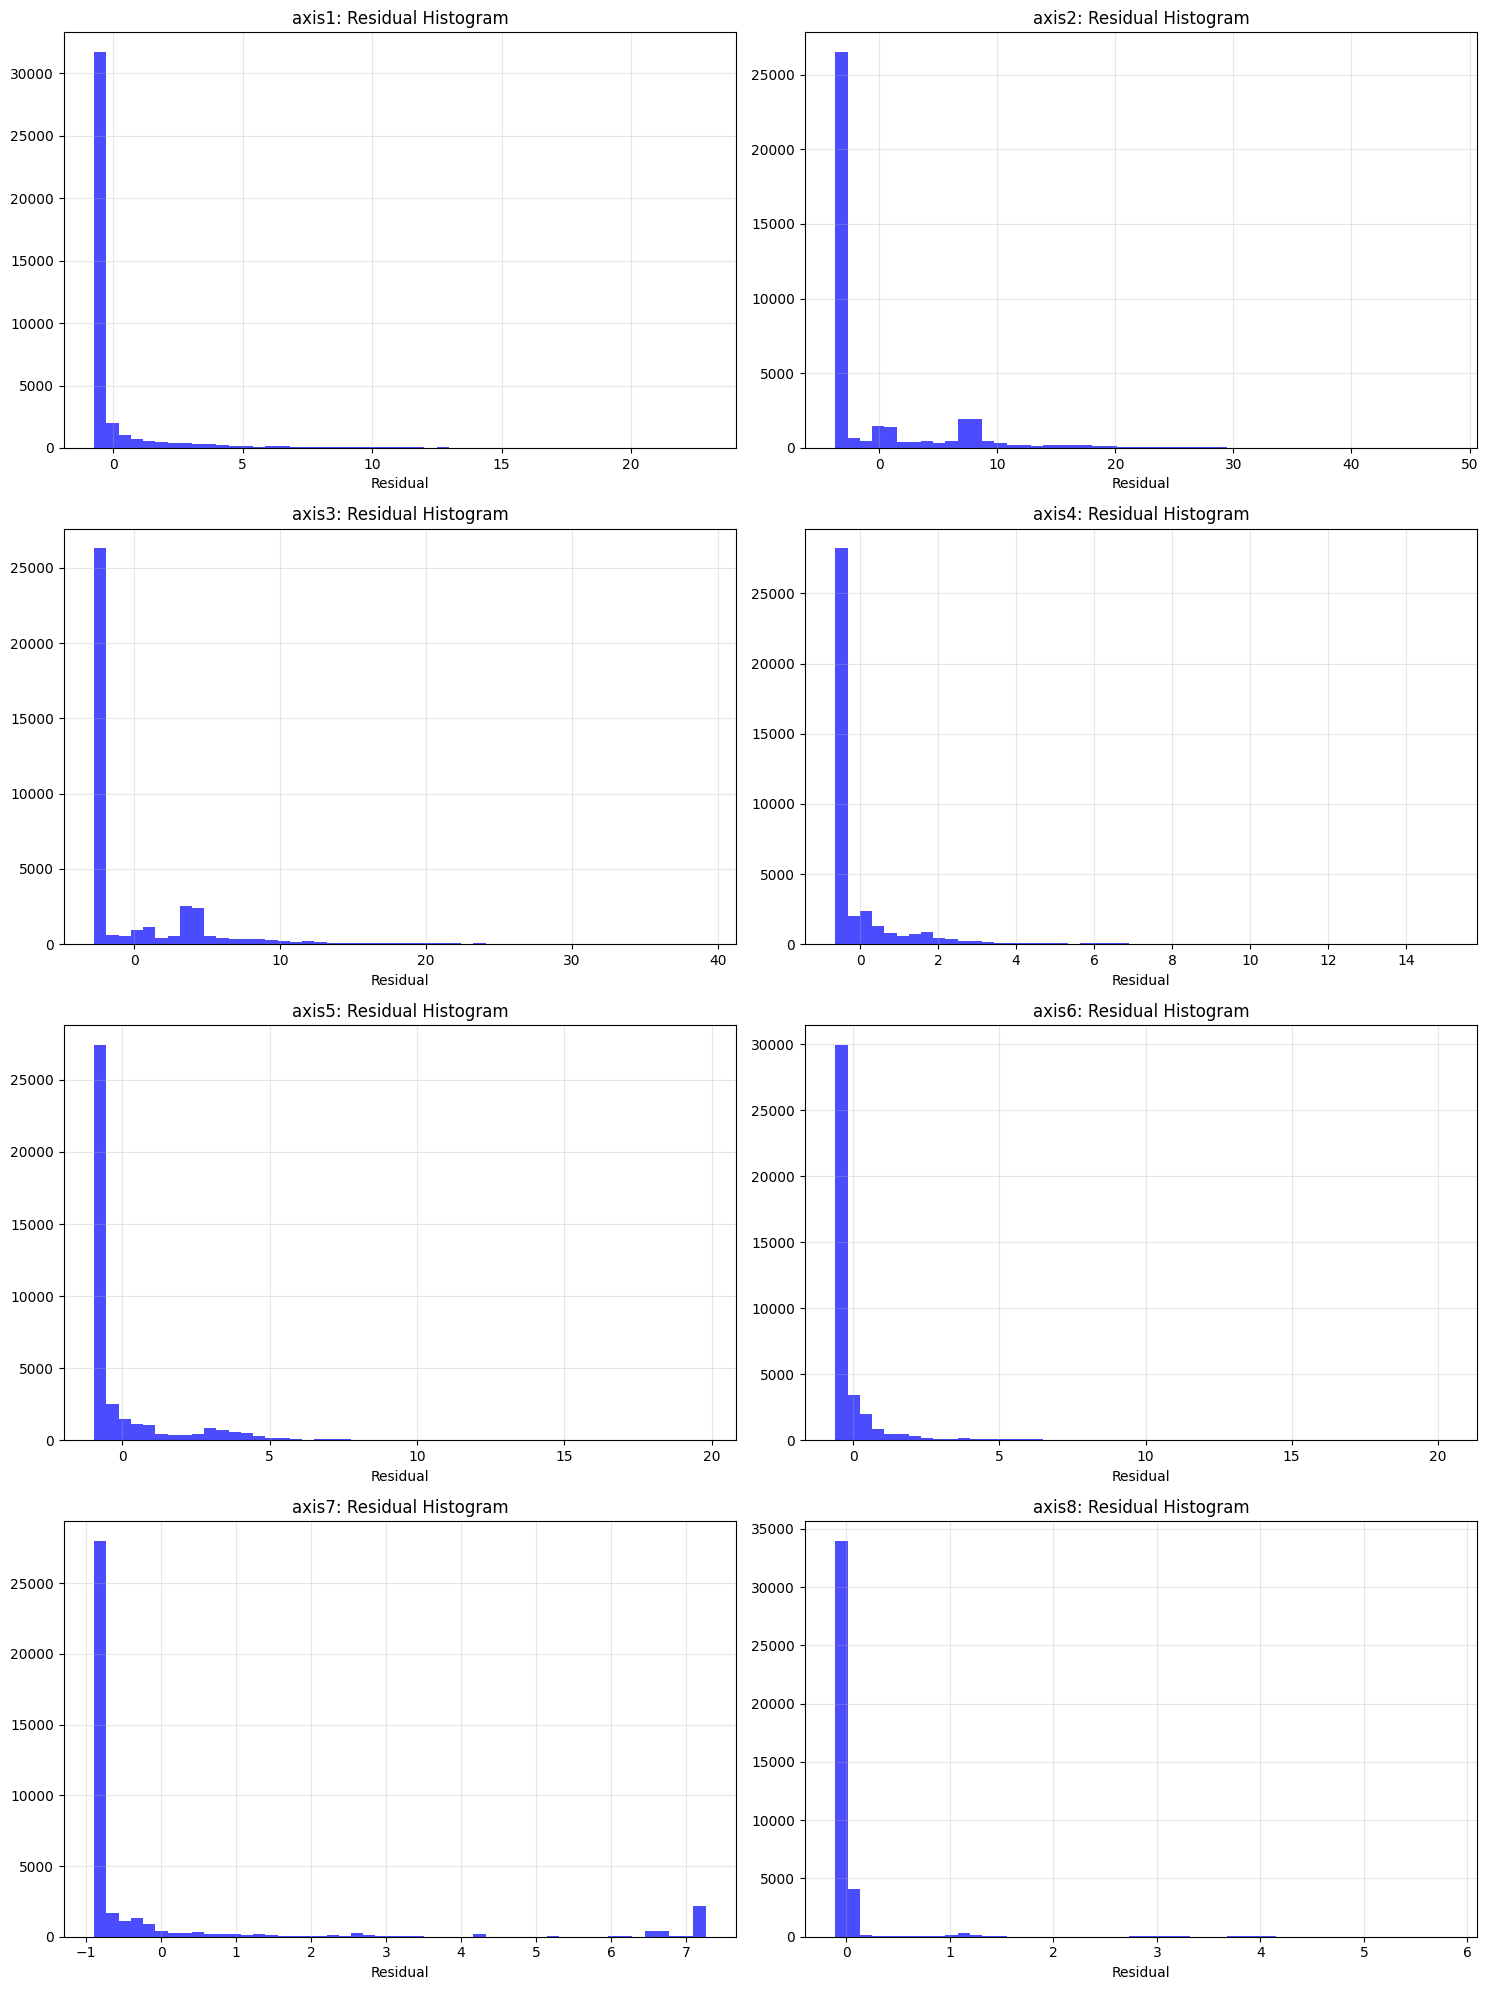

In [99]:
import matplotlib.dates as mdates


# Plot regression lines
fig, axs = plt.subplots(4, 2, figsize=(15, 20), sharex=True)
axs = axs.flatten()

for i, axis in enumerate(AXES):
    axs[i].scatter(df_train['time_numeric'], df_train[axis], s=5, alpha=0.5, label='Data')
    y_pred = models[axis].predict(X)
    axs[i].plot(df_train['time_numeric'], y_pred, color='red', label='Regression Line')
    axs[i].set_title(f'{axis}: Data vs Time')
    axs[i].set_ylabel(axis)
    axs[i].legend()
    axs[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("images/axis1_regression_fit_plot.png")  # save figure BEFORE plt.show()
plt.show()

# Plot residual distributions
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()

for i, axis in enumerate(AXES):
    axs[i].hist(residuals_dict[axis], bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'{axis}: Residual Histogram')
    axs[i].set_xlabel('Residual')
    axs[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("images/axis1_histograms_plot.png")  # save BEFORE plt.show()
plt.show()



## Threshold Discovery 

In [100]:
# --- Step 3: Threshold Discovery ---

def discover_thresholds(residuals_dict, method="percentile",
                        minc_q=97.5, maxc_q=99.5,
                        k_min=2.5, k_max=3.5):
    rows = []
    minc_by_axis = {}
    maxc_by_axis = {}
    
    for axis, res in residuals_dict.items():
        res = np.asarray(res)
        pos = res[res > 0]   # focus on positive residuals only
        if len(pos) == 0:
            pos = res  # fallback if all values <= 0

        if method == "percentile":
            MinC = float(np.percentile(pos, minc_q))
            MaxC = float(np.percentile(pos, maxc_q))
        elif method == "std":
            mu = float(np.mean(pos))
            sigma = float(np.std(pos, ddof=0))
            MinC = mu + k_min * sigma
            MaxC = mu + k_max * sigma
        else:
            raise ValueError("method must be 'percentile' or 'std'")
        
        minc_by_axis[axis] = MinC
        maxc_by_axis[axis] = MaxC
        rows.append({"axis": axis, "MinC": MinC, "MaxC": MaxC})
    
    return pd.DataFrame(rows), minc_by_axis, maxc_by_axis

# --- Calculate thresholds both ways ---
thr_table_pct, MinC_pct, MaxC_pct = discover_thresholds(
    residuals_dict, method="percentile", minc_q=95, maxc_q=98
)

thr_table_std, MinC_std, MaxC_std = discover_thresholds(
    residuals_dict, method="std", k_min=2.5, k_max=3.5
)

print(" Percentile-based thresholds:")
display(thr_table_pct)

print(" Std-based thresholds:")
display(thr_table_std)

# Save for later / README
thr_table_pct.to_csv(DATA_DIR / "thresholds_percentile.csv", index=False)
thr_table_std.to_csv(DATA_DIR / "thresholds_std.csv", index=False)


 Percentile-based thresholds:


,axis,MinC,MaxC
0,axis1,11.343826,15.557040
1,axis2,24.567595,33.815481
2,axis3,19.659364,24.923293
3,axis4,7.206002,10.611322
4,axis5,8.516996,11.642954
5,axis6,9.469247,12.932467
6,axis7,7.232741,7.244916
7,axis8,3.136179,3.918179


 Std-based thresholds:


,axis,MinC,MaxC
0,axis1,12.922450,16.784425
1,axis2,27.933964,35.763480
2,axis3,20.561974,26.383488
3,axis4,7.920240,10.342461
4,axis5,9.984031,12.809243
5,axis6,10.110378,13.305862
6,axis7,11.445049,14.359989
7,axis8,2.879637,3.839790


## Generate Synthetic Test Data (Streaming Simulation)
Use `synthetic_data.py` to generate test data mimicking a stream. Process in chunks to simulate streaming.

In [101]:
from synthetic_data import make_synthetic_test

# --- Step 4A: Generate synthetic test data ---
df_test, sample_interval_sec = make_synthetic_test(
    df_train, models, AXES,
    n_rows=5000,
    sample_interval_sec=sample_interval_sec,
    residuals_dict=residuals_dict,
    force_above=True,
    MinC=MinC,
    MaxC=MaxC
)

print(f"Synthetic raw test data generated ({len(df_test)} rows).")

# --- Step 4B: Normalize test data using training mean/std ---
norm_df = df_test.copy()
for axis in AXES:
    mean_val = df_train[axis].mean()
    std_val = df_train[axis].std()
    if std_val > 0:
        norm_df[axis] = (df_test[axis] - mean_val) / std_val

# Save normalized synthetic test data to CSV
synthetic_path = DATA_DIR / "Synthetic_test_normalized.csv"
norm_df.to_csv(synthetic_path, index=False)
print(f" Normalized synthetic test data saved to {synthetic_path}")

# --- Step 4C: Load normalized synthetic data into DB ---
table_name = "synthetic_stream"
norm_df.to_sql(table_name, engine, if_exists="replace", index=False)
print(f" Normalized synthetic test data loaded into DB (table: {table_name})")

# --- Step 4D: Simulate streaming by reading in chunks ---
chunk_size = 50
residuals_test = {axis: [] for axis in AXES}

query = f"SELECT * FROM {table_name} ORDER BY time"

for batch_num, chunk in enumerate(pd.read_sql(query, engine, chunksize=chunk_size)):
    # Only show first 2 batches for demonstration
    if batch_num < 2:
        print(f"Streaming batch {batch_num+1} (first 2 rows):")
        display(chunk.head(2))

    # Process residuals for each axis
    X_chunk = chunk[['time_numeric']].values
    for axis in AXES:
        y_pred = models[axis].predict(X_chunk)
        y_actual = chunk[axis].values
        residuals_test[axis].extend(y_actual - y_pred)

# Convert residual lists to arrays
residuals_test = {axis: np.array(vals) for axis, vals in residuals_test.items()}
print(f" Residuals computed from streamed synthetic test data ({len(residuals_test[AXES[0]])} rows total).")


Synthetic raw test data generated (5000 rows).
 Normalized synthetic test data saved to Data\Synthetic_test_normalized.csv
 Normalized synthetic test data loaded into DB (table: synthetic_stream)
Streaming batch 1 (first 2 rows):


,time,time_numeric,axis1,axis2,axis3,axis4,axis5,axis6,axis7,axis8
0,2022-10-18 10:45:00.519000+00:00,0.000,0.306933,-0.270949,0.180883,0.918419,-1.659807,0.067170,-1.021819,-0.642355
1,2022-10-18 10:45:02.410000+00:00,1.891,-1.037751,-0.312480,0.903718,0.951257,0.889568,-0.774608,-0.057818,0.099508


Streaming batch 2 (first 2 rows):


,time,time_numeric,axis1,axis2,axis3,axis4,axis5,axis6,axis7,axis8
0,2022-10-18 10:46:35.069000+00:00,94.550,0.291330,0.406207,-0.097781,-0.082523,0.042051,0.345919,0.025974,0.301131
1,2022-10-18 10:46:36.960000+00:00,96.441,0.633494,0.135241,-0.186351,-0.864730,-0.264231,0.216980,0.095674,-0.331961


 Residuals computed from streamed synthetic test data (5000 rows total).


## Implement Alerts and Errors
Detect consecutive residuals ≥ MinC/MaxC for ≥ T seconds. Log events to CSV.

In [102]:
import math, uuid
from dataclasses import dataclass

# Thresholds (percentile-based)
MinC, MaxC = MinC_pct, MaxC_pct  

# Time window setup
sample_interval_sec = float(np.nanmedian(df_train['time'].diff().dt.total_seconds()))
T_seconds = 10
rows_required = max(1, math.ceil(T_seconds / sample_interval_sec))
print(f"T = {T_seconds}s | {sample_interval_sec:.2f}s per row | rows_required={rows_required}")

@dataclass
class Event:
    event_id: str
    axis: str
    level: str       # ALERT / ERROR
    start_time: pd.Timestamp
    end_time: pd.Timestamp
    duration_sec: float
    mean_residual: float
    peak_residual: float

def detect_events_stream(df, axes, models, MinC, MaxC, rows_required):
    events, residuals_test = [], {}
    X_test = df[['time_numeric']].values

    for axis in axes:
        y, yhat = df[axis].values, models[axis].predict(X_test)
        r = y - yhat
        residuals_test[axis] = r

        streak_type, streak_start = None, None

        for i, ri in enumerate(r):
            # Decide current level
            if ri >= MaxC[axis]:
                current = "ERROR"
            elif ri >= MinC[axis]:
                current = "ALERT"
            else:
                current = None

            # Start streak
            if current and streak_type is None:
                streak_type, streak_start = current, i

            # End streak
            elif not current and streak_type:
                streak_len = i - streak_start
                if streak_len >= rows_required:
                    seg = r[streak_start:i]
                    events.append(Event(
                        event_id=str(uuid.uuid4())[:8],
                        axis=axis,
                        level=streak_type,
                        start_time=df.loc[streak_start, 'time'],
                        end_time=df.loc[i-1, 'time'],
                        duration_sec=streak_len * sample_interval_sec,
                        mean_residual=float(np.nanmean(seg)),
                        peak_residual=float(np.nanmax(seg))
                    ))
                streak_type, streak_start = None, None

        # Finalize streak if still open
        if streak_type:
            streak_len = len(r) - streak_start
            if streak_len >= rows_required:
                seg = r[streak_start:]
                events.append(Event(
                    event_id=str(uuid.uuid4())[:8],
                    axis=axis,
                    level=streak_type,
                    start_time=df.loc[streak_start, 'time'],
                    end_time=df.loc[len(r)-1, 'time'],
                    duration_sec=streak_len * sample_interval_sec,
                    mean_residual=float(np.nanmean(seg)),
                    peak_residual=float(np.nanmax(seg))
                ))

    return events, residuals_test

# Run detection
events, residuals_test = detect_events_stream(df_test, AXES, models, MinC, MaxC, rows_required)

# Save results
events_df = pd.DataFrame([e.__dict__ for e in events])
events_df.to_csv(DATA_DIR / "events_log.csv", index=False)
print(f" Saved {len(events_df)} events to Data/events_log.csv")
events_df.head()


T = 10s | 1.89s per row | rows_required=6
 Saved 10 events to Data/events_log.csv


,event_id,axis,level,start_time,end_time,duration_sec,mean_residual,peak_residual
0,77cd58ab,axis1,ERROR,2022-10-18 12:46:28.433000+00:00,2022-10-18 12:46:49.234000+00:00,22.692,18.041533,22.635169
1,4daef347,axis2,ERROR,2022-10-18 11:03:57.010000+00:00,2022-10-18 11:04:17.811000+00:00,22.692,42.081138,50.664386
2,25558912,axis2,ERROR,2022-10-18 11:52:42.387000+00:00,2022-10-18 11:53:05.079000+00:00,24.583,47.517035,57.355548
3,81c77f0a,axis4,ERROR,2022-10-18 12:43:25.006000+00:00,2022-10-18 12:43:43.916000+00:00,20.801,14.888057,17.602817
4,b69e7a15,axis4,ERROR,2022-10-18 12:47:02.471000+00:00,2022-10-18 12:47:23.272000+00:00,22.692,15.767688,18.991457


## Visualize Residuals with Alerts/Errors
Plot residuals with MinC/MaxC thresholds and annotate alerts/errors.

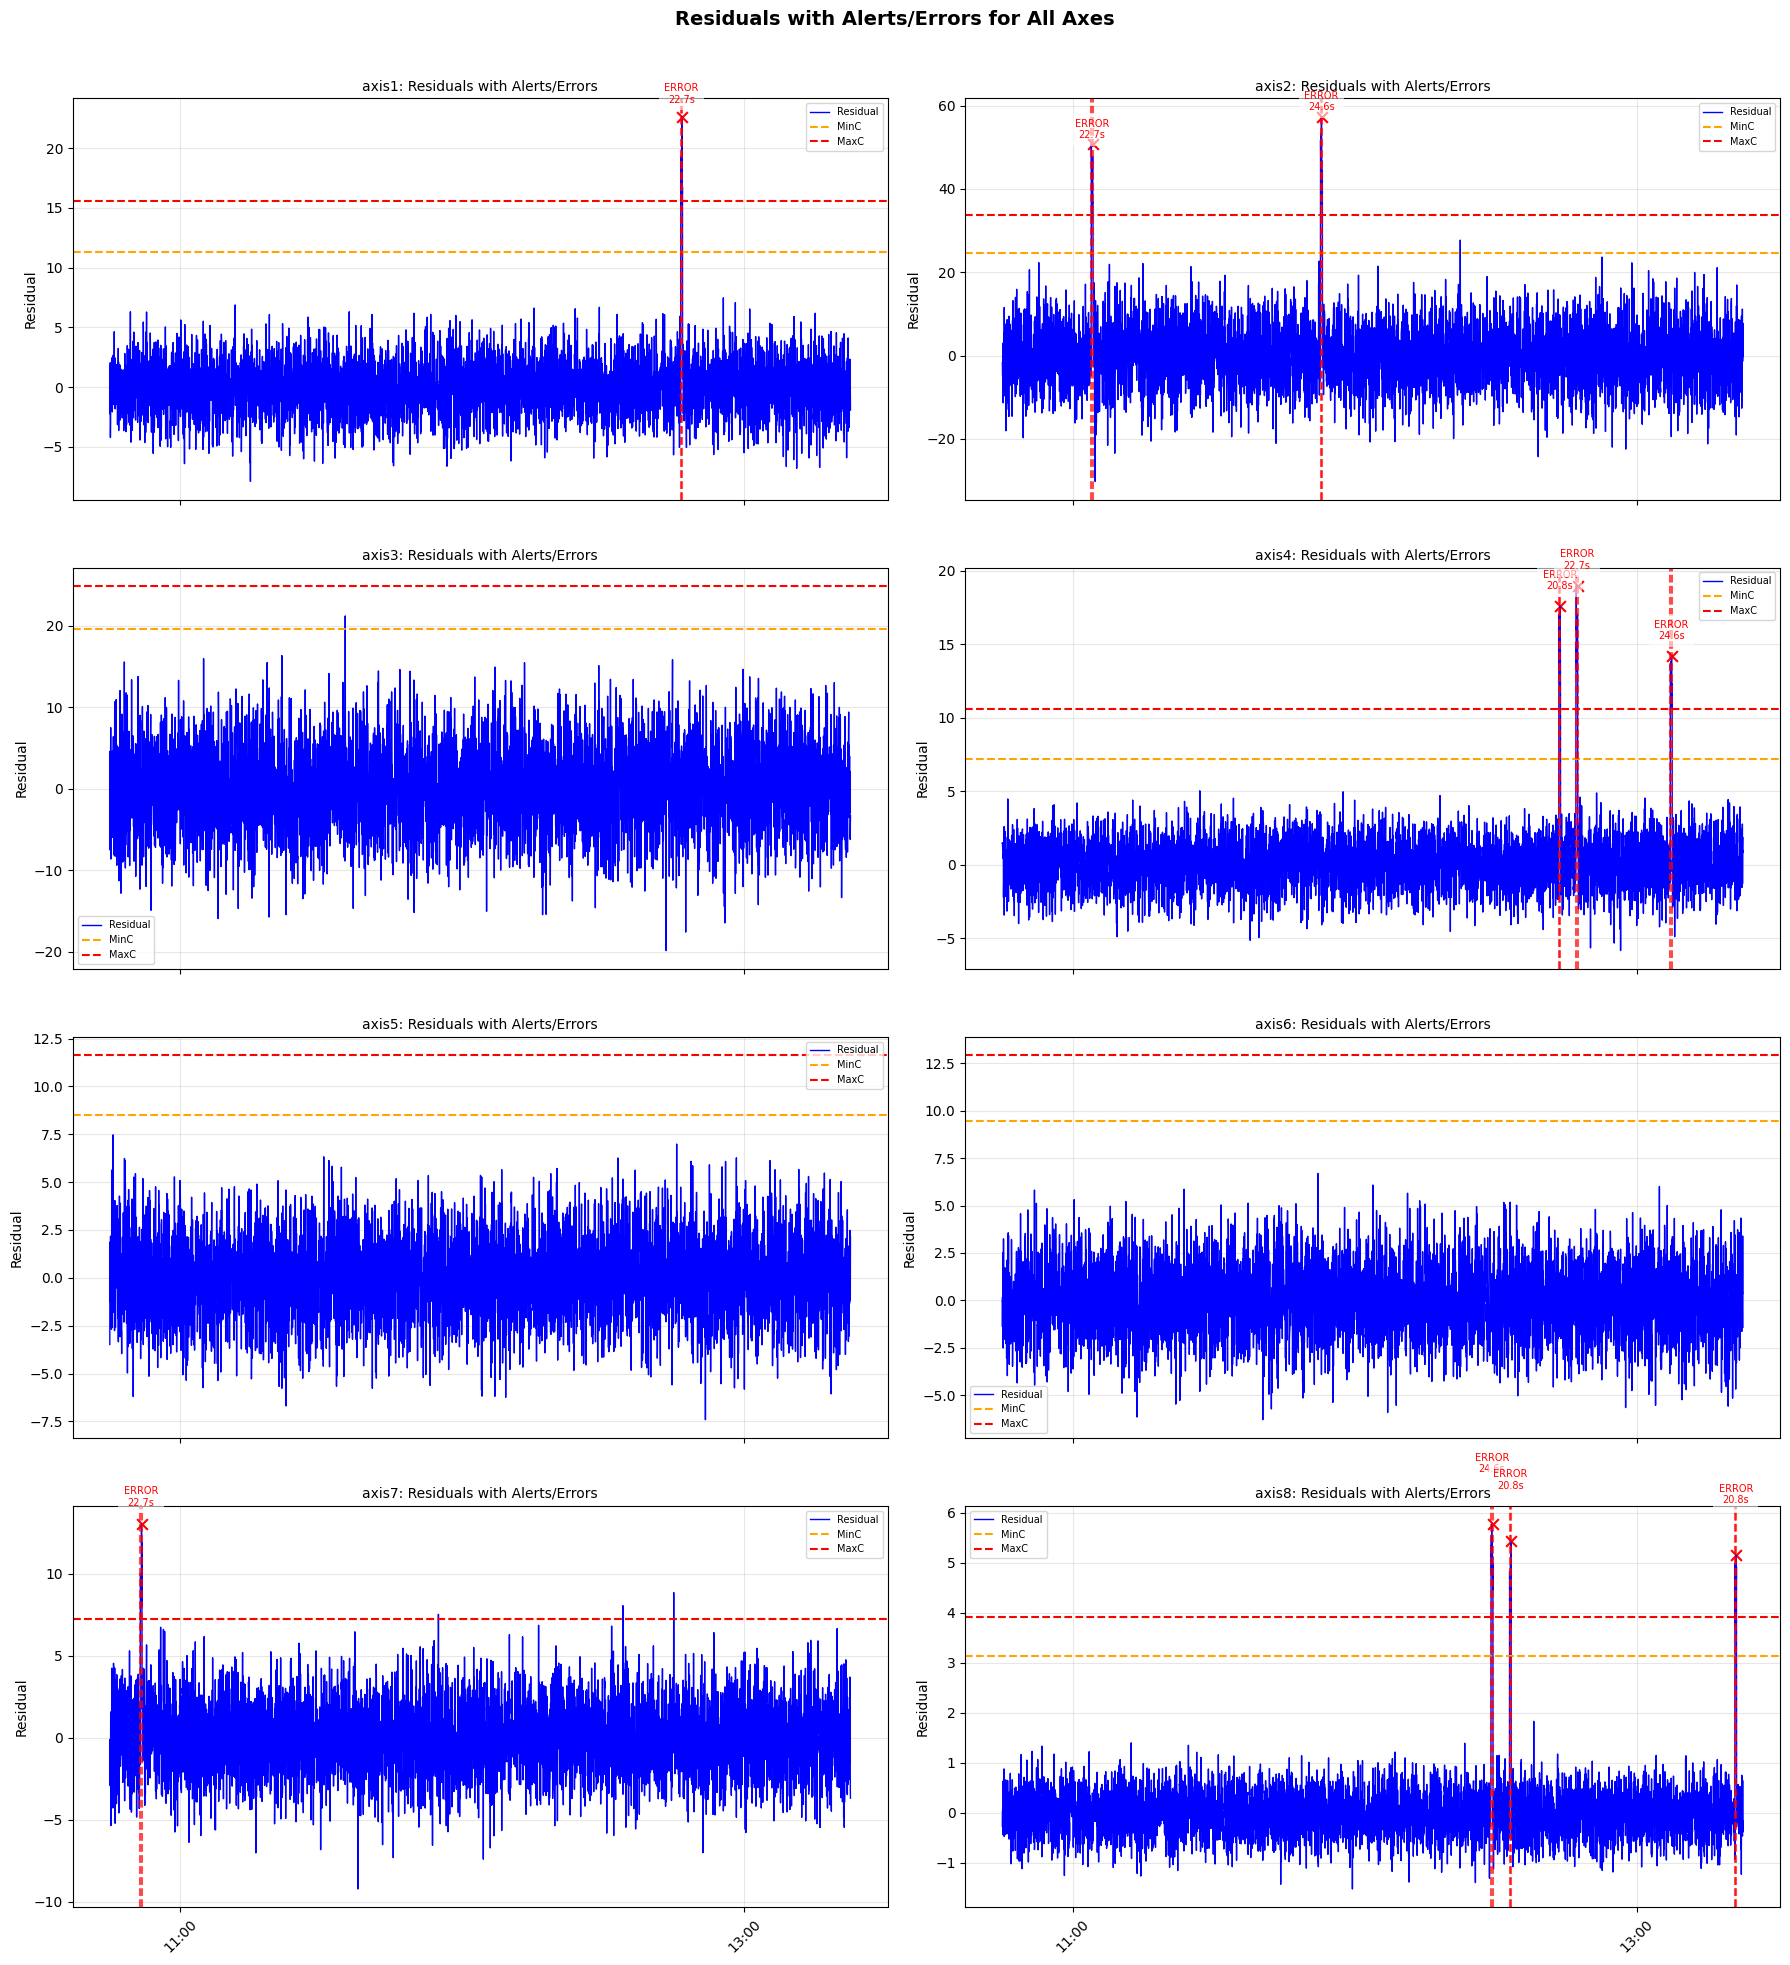

Saved combined plot: images/all_axes_residuals_with_alerts_errors.png


In [103]:
import matplotlib.dates as mdates

def plot_all_residuals_with_events(df, residuals_test, MinC, MaxC, events, axes):
    fig, axs = plt.subplots(4, 2, figsize=(18, 20), sharex=True)  # 8 subplots (4 rows × 2 cols)
    axs = axs.flatten()

    for i, axis in enumerate(axes):
        ax = axs[i]
        r = residuals_test[axis]
        t = df['time'].values

        ax.plot(t, r, color="blue", linewidth=1, label="Residual")
        ax.axhline(MinC[axis], linestyle="--", color="orange", label="MinC")
        ax.axhline(MaxC[axis], linestyle="--", color="red", label="MaxC")

        for ev in events:
            if ev.axis != axis:
                continue
            # Event spans
            ax.axvline(ev.start_time, color="green" if ev.level=="ALERT" else "red",
                       linestyle="--", alpha=0.7)
            ax.axvline(ev.end_time, color="green" if ev.level=="ALERT" else "red",
                       linestyle="--", alpha=0.7)

            # Peak point
            ax.scatter(ev.end_time, ev.peak_residual,
                       color="red" if ev.level=="ERROR" else "orange", marker="x", s=60)

            # Duration label
            mid_time = ev.start_time + (ev.end_time - ev.start_time)/2
            ax.text(mid_time, ev.peak_residual + 1,
                    f"{ev.level}\n{ev.duration_sec:.1f}s",
                    color="red" if ev.level=="ERROR" else "orange",
                    ha="center", va="bottom", fontsize=7,
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

        # Axis formatting
        ax.set_title(f"{axis}: Residuals with Alerts/Errors", fontsize=10)
        ax.set_ylabel("Residual")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=7)

        # Format x-axis only on bottom row
        if i >= len(axes) - 2:
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    fig.suptitle("Residuals with Alerts/Errors for All Axes", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    #  Save single PNG
    out_path = "images/all_axes_residuals_with_alerts_errors.png"
    plt.savefig(out_path)
    plt.show() 

    print(f"Saved combined plot: {out_path}")


# --- Run once for all axes ---
plot_all_residuals_with_events(df_test, residuals_test, MinC, MaxC, events, AXES)


## Summary
This project demonstrates a full predictive maintenance workflow:

- **Database Integration**: Connected to a Neon.tech PostgreSQL database and pulled training data for eight current axes.  
- **Regression Modeling**: Trained univariate linear regression models (Time → Axis) for all axes.  
- **Residual Analysis & Thresholds**: Computed residuals (actual – predicted) and derived thresholds using percentile analysis.  
  - **MinC** (Alert): sustained moderate deviation.  
  - **MaxC** (Error): sustained extreme deviation.  
  - **T**: persistence window (10 seconds) to filter noise.  
- **Synthetic Test Data**: Generated normalized, anomaly-injected test data aligned with training statistics.  
- **Streaming Simulation**: Loaded synthetic data into the database and replayed it in chunks to mimic real-time streaming.  
- **Alerts & Errors**: Implemented detection logic; logged all events (axis, duration, peak residual, level) to CSV.  
- **Visualization**: Produced regression fit plots, residual histograms, and combined residual plots with annotated Alert/Error events.

All outputs are stored in the `Data/` folder (CSVs) and `images/` folder (plots).  

